# Image Captioning with PyTorch (Flickr8k)

This notebook implements image captioning on the Flickr8k dataset using a PyTorch model. It maintains the same preprocessing steps and evaluation methods as the v2 notebook, but uses PyTorch for the model implementation and training.

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow  # Still needed for pad_sequences
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

In [2]:
# Converting the text files to pandas dataframe
image_tokens = pd.read_csv("Flickr8k_text/Flickr8k.lemma.token.txt", sep='\t', names=["img_id", "img_caption"])
train_image_names = pd.read_csv("Flickr8k_text/Flickr_8k.trainImages.txt", names=["img_id"])
test_image_names = pd.read_csv("Flickr8k_text/Flickr_8k.testImages.txt", names=["img_id"])
val_image_names = pd.read_csv("Flickr8k_text/Flickr_8k.devImages.txt", names=["img_id"])

In [3]:
# Just checking the number of images in the dataset
l = os.listdir("Flickr8k_Dataset/Flicker8k_Dataset")
print(len(l))

8091


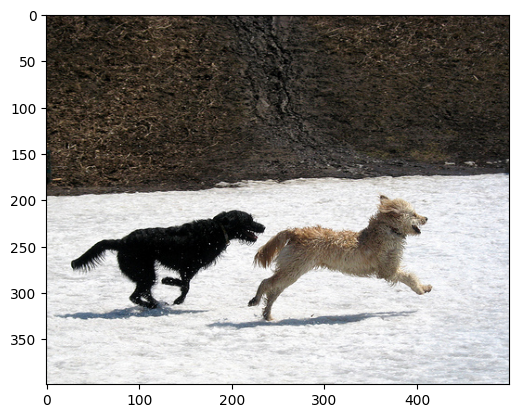

In [4]:
# Visualising one of the train images
img = cv2.imread("Flickr8k_Dataset/Flicker8k_Dataset" + "/" + train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
# Removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"] = image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [6]:
# Adding start and end tokens to captions
image_tokens["img_caption"] = image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [7]:
# Head of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [8]:
# Creating train dictionary having key as the image id and value as a list of its captions
train_captions = {}
for i in tqdm(range(len(train_image_names))):
    l = [caption for caption in (image_tokens[image_tokens["img_id"] == train_image_names["img_id"].iloc[i]].img_caption)]
    train_captions[train_image_names["img_id"].iloc[i]] = l

100%|██████████| 6000/6000 [00:07<00:00, 807.04it/s]


In [9]:
# Creating test dictionary having key as the image id and value as a list of its captions
test_captions = {}
for i in tqdm(range(len(test_image_names))):
    l = [caption for caption in (image_tokens[image_tokens["img_id"] == test_image_names["img_id"].iloc[i]].img_caption)]
    test_captions[test_image_names["img_id"].iloc[i]] = l

100%|██████████| 1000/1000 [00:01<00:00, 806.56it/s]


In [10]:
# Creating validation dictionary having key as the image id and value as a list of its captions
validation_captions = {}
for i in tqdm(range(len(val_image_names))):
    l = [caption for caption in (image_tokens[image_tokens["img_id"] == val_image_names["img_id"].iloc[i]].img_caption)]
    validation_captions[val_image_names["img_id"].iloc[i]] = l

100%|██████████| 1000/1000 [00:01<00:00, 802.09it/s]


# Load Pre-Extracted Features

We'll load the pre-extracted ResNet50 features from the existing pickle files.

In [11]:
# Load pre-extracted features
with open("train_encoded_images.p", "rb") as pickle_f:
    train_features = pickle.load(pickle_f)
    
with open("test_encoded_images.p", "rb") as pickle_f:
    test_features = pickle.load(pickle_f)
    
with open("validation_encoded_images.p", "rb") as pickle_f:
    validation_features = pickle.load(pickle_f)

In [12]:
# Check the feature dimension
for img_id in train_features:
    print(f"Feature shape: {train_features[img_id].shape}")
    break

Feature shape: (2048,)


In [13]:
# Build vocabulary from captions
all_captions = []
for img_id in tqdm(train_captions):
    for caption in train_captions[img_id]:
        all_captions.append(caption)

all_words = " ".join(all_captions)
print(f"Total words: {len(all_words)}")
unique_words = list(set(all_words.strip().split(" ")))
print(f"Unique words: {len(unique_words)}")

# Define max_length and vocabulary size
vocab_size = len(unique_words) + 1
max_length = 40

# Form dictionaries mapping words to indices and indices to words
words_to_indices = {val: index+1 for index, val in enumerate(unique_words)}
indices_to_words = {index+1: val for index, val in enumerate(unique_words)}
words_to_indices["Unk"] = 0
indices_to_words[0] = "Unk"

100%|██████████| 6000/6000 [00:00<00:00, 1999986.01it/s]

Total words: 1991192
Unique words: 6328


In [14]:
# Encode and pad captions
train_encoded_captions = {}
for img_id in tqdm(train_captions):
    train_encoded_captions[img_id] = []
    for i in range(5):
        train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])
    train_encoded_captions[img_id] = pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

# Print a sample of encoded captions
for img_id in train_encoded_captions:
    print(train_encoded_captions[img_id])
    break

100%|██████████| 6000/6000 [00:00<00:00, 69353.32it/s]

[[4225 3505 4616 3308  516 6100 3118 4737  421 3308 4721  154 1089 1722
  5720    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4225 4199 3308 2295 2098 3308 2031 1089 5720    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4225   93 3308 2295 4447 1754 2186  154 1262  596 1722 5720    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4225   93 3308 5572 3041 4721  154 1089 1722 5720    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4225   93 3308 6100 2031 4737  137 2516 2176 3722 5037 1722 5720    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

# PyTorch Dataset and DataLoader

Replace the Keras data generator with PyTorch Dataset and DataLoader.

In [ ]:
# Custom PyTorch Dataset
class FlickrDataset(Dataset):
    def __init__(self, features_dict, captions_dict):
        self.image_ids = list(features_dict.keys())
        self.features = features_dict
        self.captions = captions_dict
        self.max_length = max_length
        
    def __len__(self):
        return len(self.image_ids) * 5  # 5 captions per image
        
    def __getitem__(self, idx):
        img_idx = idx // 5
        cap_idx = idx % 5
        img_id = self.image_ids[img_idx]
        feature = torch.tensor(self.features[img_id], dtype=torch.float32)
        caption = self.captions[img_id][cap_idx]
        
        # For each position in caption, predict the next word
        samples = []
        for i in range(1, len(caption)):
            if caption[i] == 0:  # padding
                continue
            input_seq = caption[:i]
            target = caption[i]
            samples.append((feature, input_seq, target))
            
        return samples
    
# Collate function to handle multiple samples per __getitem__
def collate_fn(batch):
    # Flatten the batch
    batch = [item for sublist in batch for item in sublist]
    
    features = []
    input_seqs = []
    targets = []
    
    for feature, input_seq, target in batch:
        features.append(feature)
        input_seqs.append(input_seq)
        targets.append(target)
    
    # Convert to tensors
    features = torch.stack(features)
    # Pad input sequences
    max_len = max(len(seq) for seq in input_seqs)
    padded_seqs = np.zeros((len(input_seqs), max_len))
    for i, seq in enumerate(input_seqs):
        padded_seqs[i, :len(seq)] = seq
    input_seqs = torch.tensor(padded_seqs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    
    return features, input_seqs, targets

In [16]:
# Create datasets and dataloaders
batch_size = 128

train_dataset = FlickrDataset(train_features, train_encoded_captions)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=0  # Set to higher value if CUDA is available
)

# Use a subset of the training data for validation instead of validation features
# This ensures we have matching captions for all images
validation_subset = {}
validation_captions_encoded = {}
validation_image_ids = list(train_features.keys())[:100]  # Just use first 100 training images for validation
for img_id in validation_image_ids:
    validation_subset[img_id] = train_features[img_id]
    validation_captions_encoded[img_id] = train_encoded_captions[img_id]

val_dataset = FlickrDataset(validation_subset, validation_captions_encoded)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

# PyTorch Model Architecture

Replace the Keras model with a PyTorch model that has similar architecture. We'll use a combination of embedding, LSTM, and fully connected layers.

In [ ]:
# PyTorch model definition
class ImageCaptionModel(nn.Module):
    def __init__(self, feature_dim, vocab_size, embed_dim=256, hidden_dim=256, dropout_rate=0.2):
        super(ImageCaptionModel, self).__init__()
        
        # Image feature processing
        self.image_fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, embed_dim),
            nn.ReLU()
        )
        
        # Caption processing
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.caption_dropout = nn.Dropout(dropout_rate)
        # Two-layer LSTM for increased model capacity
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True)
    
        # Decoder
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size)
        )
        
    def forward(self, image_features, captions):
        # Process image features
        img_features = self.image_fc(image_features)  # (batch_size, embed_dim)
        
        # Process captions
        cap_features = self.embedding(captions)  # (batch_size, seq_len, embed_dim)
        cap_features = self.caption_dropout(cap_features)
        
        # LSTM processing (use last hidden state)
        lstm_out, (hidden, _) = self.lstm(cap_features)
        
        # Add image features to LSTM output
        combined = lstm_out[:, -1, :] + img_features
        
        # Decode
        output = self.fc(combined)
        
        return output

In [50]:
# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
feature_dim = next(iter(train_features.values())).shape[0]  # 2048 for ResNet50
model = ImageCaptionModel(feature_dim, vocab_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

Using device: cuda


In [51]:
# Training loop
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
best_epoch = -1

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for features, captions, targets in progress_bar:
        features = features.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(features, captions)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_train_loss = train_loss / train_batches
    history['train_loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for features, captions, targets in progress_bar:
            features = features.to(device)
            captions = captions.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(features, captions)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            val_batches += 1
            progress_bar.set_postfix({"loss": loss.item()})
    
    avg_val_loss = val_loss / val_batches
    history['val_loss'].append(avg_val_loss)
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_flickr_caption_model.pt')
        print(f"New best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 44.45it/s, loss=4.09]


New best model saved at epoch 1 with validation loss: 4.0045
Epoch 1/50, Train Loss: 4.9515, Val Loss: 4.0045


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 57.95it/s, loss=3.21]


New best model saved at epoch 2 with validation loss: 3.1236
Epoch 2/50, Train Loss: 3.5026, Val Loss: 3.1236


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 60.59it/s, loss=2.9]


New best model saved at epoch 3 with validation loss: 2.8318
Epoch 3/50, Train Loss: 3.0635, Val Loss: 2.8318


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 52.97it/s, loss=2.7]


New best model saved at epoch 4 with validation loss: 2.6424
Epoch 4/50, Train Loss: 2.8408, Val Loss: 2.6424


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 54.54it/s, loss=2.56]


New best model saved at epoch 5 with validation loss: 2.4949
Epoch 5/50, Train Loss: 2.6778, Val Loss: 2.4949


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 61.71it/s, loss=2.44]


New best model saved at epoch 6 with validation loss: 2.3694
Epoch 6/50, Train Loss: 2.5488, Val Loss: 2.3694


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 61.64it/s, loss=2.33]


New best model saved at epoch 7 with validation loss: 2.2591
Epoch 7/50, Train Loss: 2.4410, Val Loss: 2.2591


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 45.19it/s, loss=2.24]


New best model saved at epoch 8 with validation loss: 2.1685
Epoch 8/50, Train Loss: 2.3476, Val Loss: 2.1685


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 51.27it/s, loss=2.16]


New best model saved at epoch 9 with validation loss: 2.1005
Epoch 9/50, Train Loss: 2.2695, Val Loss: 2.1005


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 54.18it/s, loss=2.09]


New best model saved at epoch 10 with validation loss: 2.0337
Epoch 10/50, Train Loss: 2.2004, Val Loss: 2.0337


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 63.98it/s, loss=2.06]


New best model saved at epoch 11 with validation loss: 1.9816
Epoch 11/50, Train Loss: 2.1434, Val Loss: 1.9816


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 58.39it/s, loss=2]


New best model saved at epoch 12 with validation loss: 1.9188
Epoch 12/50, Train Loss: 2.0892, Val Loss: 1.9188


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s, loss=1.94]


New best model saved at epoch 13 with validation loss: 1.8697
Epoch 13/50, Train Loss: 2.0411, Val Loss: 1.8697


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 47.29it/s, loss=1.87]


New best model saved at epoch 14 with validation loss: 1.8263
Epoch 14/50, Train Loss: 1.9953, Val Loss: 1.8263


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 49.07it/s, loss=1.82]


New best model saved at epoch 15 with validation loss: 1.7853
Epoch 15/50, Train Loss: 1.9567, Val Loss: 1.7853


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 65.03it/s, loss=1.79]


New best model saved at epoch 16 with validation loss: 1.7429
Epoch 16/50, Train Loss: 1.9183, Val Loss: 1.7429


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 53.45it/s, loss=1.75]


New best model saved at epoch 17 with validation loss: 1.7081
Epoch 17/50, Train Loss: 1.8838, Val Loss: 1.7081


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 63.68it/s, loss=1.72]


New best model saved at epoch 18 with validation loss: 1.6744
Epoch 18/50, Train Loss: 1.8517, Val Loss: 1.6744


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 42.77it/s, loss=1.68]


New best model saved at epoch 19 with validation loss: 1.6316
Epoch 19/50, Train Loss: 1.8185, Val Loss: 1.6316


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 53.32it/s, loss=1.64]


New best model saved at epoch 20 with validation loss: 1.5959
Epoch 20/50, Train Loss: 1.7912, Val Loss: 1.5959


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 53.68it/s, loss=1.6]


New best model saved at epoch 21 with validation loss: 1.5557
Epoch 21/50, Train Loss: 1.7615, Val Loss: 1.5557


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 41.87it/s, loss=1.57]


New best model saved at epoch 22 with validation loss: 1.5375
Epoch 22/50, Train Loss: 1.7377, Val Loss: 1.5375


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 61.20it/s, loss=1.55]


New best model saved at epoch 23 with validation loss: 1.5043
Epoch 23/50, Train Loss: 1.7142, Val Loss: 1.5043


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 59.25it/s, loss=1.49]


New best model saved at epoch 24 with validation loss: 1.4731
Epoch 24/50, Train Loss: 1.6911, Val Loss: 1.4731


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 50.26it/s, loss=1.5]


New best model saved at epoch 25 with validation loss: 1.4582
Epoch 25/50, Train Loss: 1.6660, Val Loss: 1.4582


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 53.32it/s, loss=1.47]


New best model saved at epoch 26 with validation loss: 1.4330
Epoch 26/50, Train Loss: 1.6456, Val Loss: 1.4330


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 65.03it/s, loss=1.44]


New best model saved at epoch 27 with validation loss: 1.3995
Epoch 27/50, Train Loss: 1.6242, Val Loss: 1.3995


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 48.88it/s, loss=1.42]


New best model saved at epoch 28 with validation loss: 1.3874
Epoch 28/50, Train Loss: 1.6052, Val Loss: 1.3874


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 57.13it/s, loss=1.41]


New best model saved at epoch 29 with validation loss: 1.3701
Epoch 29/50, Train Loss: 1.5868, Val Loss: 1.3701


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 56.33it/s, loss=1.37]


New best model saved at epoch 30 with validation loss: 1.3431
Epoch 30/50, Train Loss: 1.5684, Val Loss: 1.3431


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 63.14it/s, loss=1.36]


New best model saved at epoch 31 with validation loss: 1.3336
Epoch 31/50, Train Loss: 1.5500, Val Loss: 1.3336


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 56.32it/s, loss=1.32]


New best model saved at epoch 32 with validation loss: 1.3093
Epoch 32/50, Train Loss: 1.5332, Val Loss: 1.3093


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 47.61it/s, loss=1.31]


New best model saved at epoch 33 with validation loss: 1.2890
Epoch 33/50, Train Loss: 1.5170, Val Loss: 1.2890


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 57.19it/s, loss=1.29]


New best model saved at epoch 34 with validation loss: 1.2686
Epoch 34/50, Train Loss: 1.5000, Val Loss: 1.2686


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 46.77it/s, loss=1.27]


New best model saved at epoch 35 with validation loss: 1.2472
Epoch 35/50, Train Loss: 1.4872, Val Loss: 1.2472


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 52.97it/s, loss=1.24]


New best model saved at epoch 36 with validation loss: 1.2312
Epoch 36/50, Train Loss: 1.4686, Val Loss: 1.2312


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 55.93it/s, loss=1.22]


New best model saved at epoch 37 with validation loss: 1.2120
Epoch 37/50, Train Loss: 1.4561, Val Loss: 1.2120


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 49.67it/s, loss=1.2]


New best model saved at epoch 38 with validation loss: 1.1973
Epoch 38/50, Train Loss: 1.4419, Val Loss: 1.1973


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 52.96it/s, loss=1.19]


New best model saved at epoch 39 with validation loss: 1.1763
Epoch 39/50, Train Loss: 1.4287, Val Loss: 1.1763


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 62.96it/s, loss=1.18]


New best model saved at epoch 40 with validation loss: 1.1609
Epoch 40/50, Train Loss: 1.4152, Val Loss: 1.1609


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 41.44it/s, loss=1.14]


New best model saved at epoch 41 with validation loss: 1.1464
Epoch 41/50, Train Loss: 1.4015, Val Loss: 1.1464


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 53.69it/s, loss=1.14]


New best model saved at epoch 42 with validation loss: 1.1299
Epoch 42/50, Train Loss: 1.3909, Val Loss: 1.1299


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 45.70it/s, loss=1.12]


New best model saved at epoch 43 with validation loss: 1.1174
Epoch 43/50, Train Loss: 1.3750, Val Loss: 1.1174


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 54.22it/s, loss=1.12]


New best model saved at epoch 44 with validation loss: 1.1150
Epoch 44/50, Train Loss: 1.3644, Val Loss: 1.1150


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 46.77it/s, loss=1.09]


New best model saved at epoch 45 with validation loss: 1.0923
Epoch 45/50, Train Loss: 1.3506, Val Loss: 1.0923


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 54.41it/s, loss=1.07]


New best model saved at epoch 46 with validation loss: 1.0722
Epoch 46/50, Train Loss: 1.3426, Val Loss: 1.0722


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 60.60it/s, loss=1.08]


New best model saved at epoch 47 with validation loss: 1.0643
Epoch 47/50, Train Loss: 1.3314, Val Loss: 1.0643


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 61.06it/s, loss=1.07]


New best model saved at epoch 48 with validation loss: 1.0540
Epoch 48/50, Train Loss: 1.3203, Val Loss: 1.0540


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 48.10it/s, loss=1.05]


New best model saved at epoch 49 with validation loss: 1.0399
Epoch 49/50, Train Loss: 1.3110, Val Loss: 1.0399


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 59.68it/s, loss=1.04]

New best model saved at epoch 50 with validation loss: 1.0333
Epoch 50/50, Train Loss: 1.2988, Val Loss: 1.0333


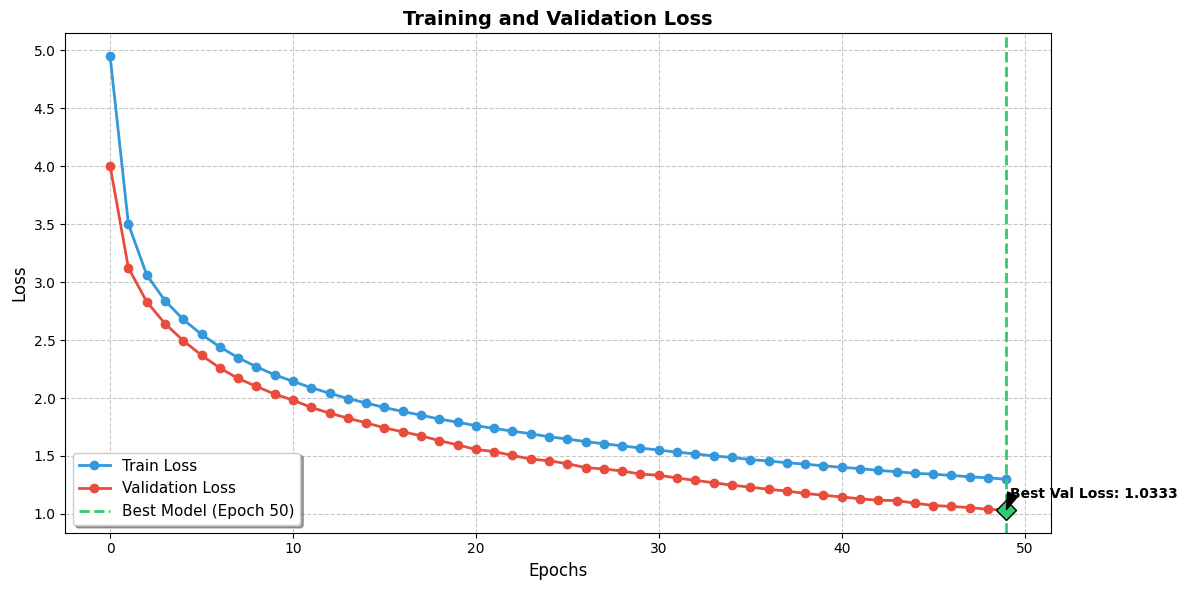

In [52]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], 'o-', color='#3498db', linewidth=2, markersize=6, label='Train Loss')
plt.plot(history['val_loss'], 'o-', color='#e74c3c', linewidth=2, markersize=6, label='Validation Loss')

# Mark the best model with a vertical line
if best_epoch >= 0:
    plt.axvline(x=best_epoch, linestyle='--', color='#2ecc71', linewidth=2, 
                label=f'Best Model (Epoch {best_epoch+1})')
    # Mark the lowest validation loss point
    best_val_loss_value = history['val_loss'][best_epoch]
    plt.plot(best_epoch, best_val_loss_value, 'D', color='#2ecc71', 
             markersize=10, markeredgecolor='black')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=11, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotation for best val loss
if best_epoch >= 0:
    plt.annotate(f'Best Val Loss: {history["val_loss"][best_epoch]:.4f}',
                xy=(best_epoch, history['val_loss'][best_epoch]),
                xytext=(best_epoch + 0.2, history['val_loss'][best_epoch] * 1.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [53]:
# Load the best model
model.load_state_dict(torch.load('best_flickr_caption_model.pt'))
model.eval()

C:\Users\CM_PC\AppData\Local\Temp\ipykernel_15316\3507882008.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_flickr_caption_model.

ImageCaptionModel(
  (image_fc): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
  )
  (embedding): Embedding(6329, 256)
  (caption_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6329, bias=True)
  )
)

# Caption Generation Functions

Implement greedy search and beam search in PyTorch, maintaining the same function signatures as in the v2 notebook.

In [ ]:
# Greedy search implementation in PyTorch
# This function generates a caption by always choosing the most probable next word
def greedy_search(photo):
    # Reshape photo to match model input
    photo = torch.tensor(photo, dtype=torch.float32).unsqueeze(0).to(device)
    in_text = '<start>'
    
    for i in range(max_length):
        # Encode current text to sequence
        sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        sequence = torch.tensor(sequence, dtype=torch.long).to(device)
        
        # Predict next word
        with torch.no_grad():
            output = model(photo, sequence)
        
        # Get most likely word prediction
        y_pred = torch.argmax(output, dim=1).item()
        word = indices_to_words.get(y_pred, 'Unk')
        
        # Append predicted word to text
        in_text += ' ' + word
        if word == '<end>':
            break
    
    # Return final caption list (without start/end tokens)
    final = in_text.split()
    final = final[1:-1] if final[-1] == '<end>' else final[1:]
    return final

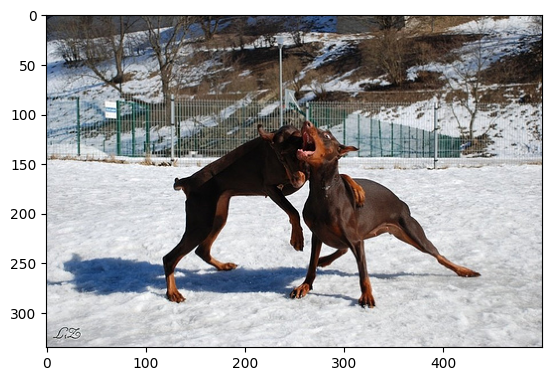

Reference Captions:
  Dog be in the snow in front of a fence .
  Dog play on the snow .
  Two brown dog playful fight in the snow .
  Two brown dog wrestle in the snow .
  Two dog play in the snow .
Predicted Caption (Greedy Search):
  Two dog play in the snow .
BLEU score: 1.0
------------------------------------------------------------


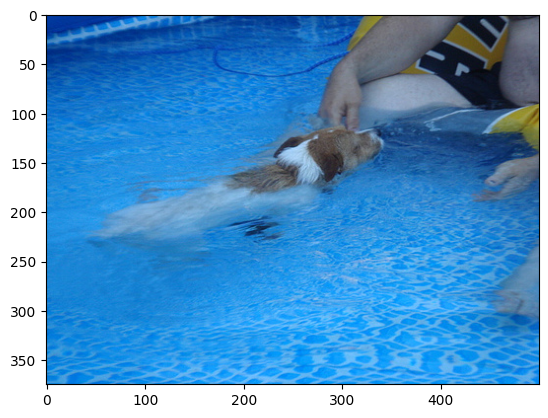

Reference Captions:
  a brown and white dog swim towards some in a pool
  A dog in a swim pool swim toward sombody we cannot see .
  A dog swim in a pool near a person .
  Small dog be paddle through the water in a pool .
  A small brown and white dog be in a pool .
Predicted Caption (Greedy Search):
  A boy in a blue shirt be dive into a pool .
BLEU score: 4.337579510280189e-78
------------------------------------------------------------


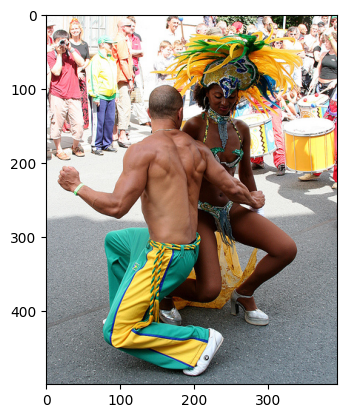

Reference Captions:
  A man and a woman in festive costume dance .
  A man and a woman with feather on her head dance .
  A man and a woman wear decorative costume and dance in a crowd of onlooker .
  one performer wear a feathered headdress dance with another performer in street
  Two person be dance with drum on the right and a crowd behind them .
Predicted Caption (Greedy Search):
  A man in a colorful shirt be hold a baby in a colorful hat .
BLEU score: 7.57965434483665e-155
------------------------------------------------------------


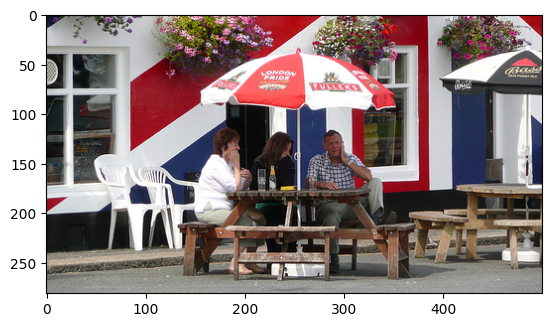

Reference Captions:
  A couple of person sit outdoors at a table with an umbrella and talk .
  Three person be sit at an outside picnic bench with an umbrella .
  Three person sit at an outdoor cafe .
  Three person sit at an outdoor table in front of a building paint like the Union Jack .
  Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption (Greedy Search):
  A girl be stand by a man and a girl in a red and white sweatshirt on a merry-go-round .
BLEU score: 1.4488496539373276e-231
------------------------------------------------------------


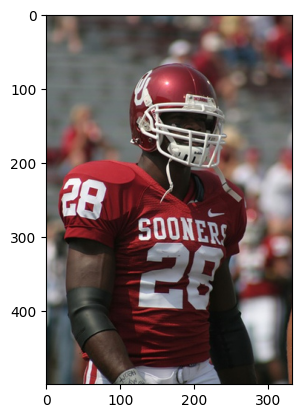

Reference Captions:
  A man be wear a Sooner red football shirt and helmet .
  A Oklahoma Sooner football player wear his jersey number 28 .
  A Sooner football player weas the number 28 and black armband .
  Guy in red and white football uniform
  The American footballer be wear a red and white strip .
Predicted Caption (Greedy Search):
  A football player in a red football uniform be watch the man from the ground .
BLEU score: 9.760736177364437e-155
------------------------------------------------------------


In [55]:
# Test greedy search on a few images
i = 0
for img_id in test_features:
    i += 1
    img = cv2.imread("Flickr8k_Dataset/Flicker8k_Dataset" + "/" + img_id)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    photo = test_features[img_id]
    plt.show()
    
    reference = []
    for caps in test_captions[img_id]:
        list_caps = caps.split(" ")
        list_caps = list_caps[1:-1]
        reference.append(list_caps)
        
    candidate = greedy_search(photo)
    score = sentence_bleu(reference, candidate)
    
    print("Reference Captions:")
    for cap in reference:
        print("  " + " ".join(cap))
        
    print("Predicted Caption (Greedy Search):")
    print("  " + " ".join(candidate))
    print("BLEU score:", score)
    print("-" * 60)
    
    if i == 5:
        break

In [56]:
# Calculate average BLEU score on test set using greedy search
i = 0
tot_score = 0
for img_id in tqdm(test_features):
    i += 1
    photo = test_features[img_id]
    
    reference = []
    for caps in test_captions[img_id]:
        list_caps = caps.split(" ")
        list_caps = list_caps[1:-1]
        reference.append(list_caps)
        
    candidate = greedy_search(photo)
    score = sentence_bleu(reference, candidate)
    tot_score += score
    
avg_score = tot_score / i
print("BLEU score on Greedy search")
print("Score:", avg_score)

100%|██████████| 1000/1000 [00:20<00:00, 49.90it/s]

BLEU score on Greedy search
Score: 0.09435558207042842


In [ ]:
# Beam search implementation in PyTorch
# This function keeps the top-k most probable sequences at each step for more diverse and accurate captions
def beam_search(photo, k=3):
    # Reshape photo to match model input
    photo = torch.tensor(photo, dtype=torch.float32).unsqueeze(0).to(device)
    in_text = '<start>'
    
    # Get initial predictions
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    sequence = torch.tensor(sequence, dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(photo, sequence)
    
    # Convert to probabilities
    output = torch.softmax(output, dim=1).cpu().numpy().flatten()
    
    # Get top k initial predictions
    indices = np.argsort(output)[-k:][::-1]
    
    # Initialize beam search with top k candidates
    b_search = []
    for idx in indices:
        word = indices_to_words[idx]
        b_search.append((in_text + ' ' + word, float(output[idx])))
    
    # Continue beam search for max_length steps
    for _ in range(max_length):
        b_search_square = []
        
        for text, score in b_search:
            # Stop extending if the last word is <end>
            if text.split()[-1] == "<end>":
                b_search_square.append((text, score))
                continue
                
            # Encode current text to sequence
            sequence = [words_to_indices[s] for s in text.split(" ") if s in words_to_indices]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            sequence = torch.tensor(sequence, dtype=torch.long).to(device)
            
            # Predict next word probabilities
            with torch.no_grad():
                output = model(photo, sequence)
            
            # Convert to probabilities
            output = torch.softmax(output, dim=1).cpu().numpy().flatten()
            
            # Get top k predictions for this candidate
            indices = np.argsort(output)[-k:][::-1]
            
            for idx in indices:
                word = indices_to_words[idx]
                b_search_square.append((text + ' ' + word, score * float(output[idx])))
        
        # Keep only the k best candidates
        if len(b_search_square) > 0:
            b_search = sorted(b_search_square, key=lambda x: x[1], reverse=True)[:k]
    
    # Return the best sequence
    final = b_search[0][0].split()
    final = final[1:-1] if final[-1] == '<end>' else final[1:]
    return final

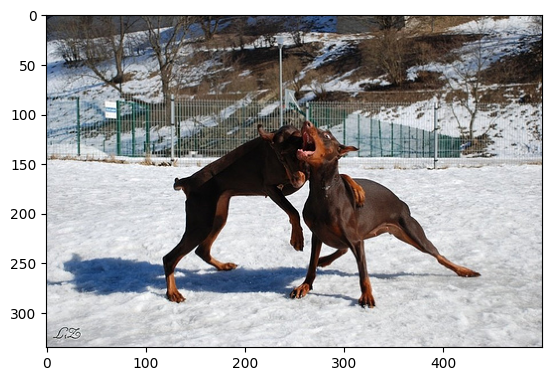

Reference Captions:
  Dog be in the snow in front of a fence .
  Dog play on the snow .
  Two brown dog playful fight in the snow .
  Two brown dog wrestle in the snow .
  Two dog play in the snow .
Predicted Caption (Beam Search, k=3):
  Two dog play in the snow .
BLEU score: 1.0
------------------------------------------------------------


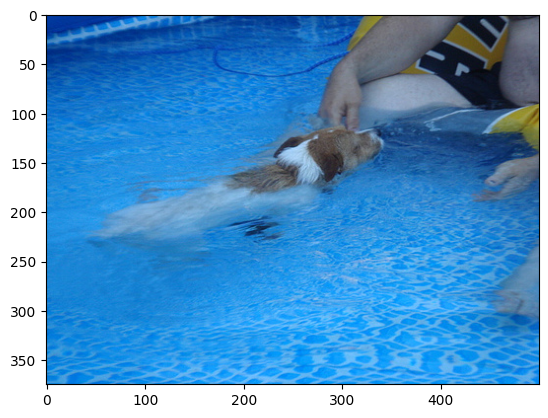

Reference Captions:
  a brown and white dog swim towards some in a pool
  A dog in a swim pool swim toward sombody we cannot see .
  A dog swim in a pool near a person .
  Small dog be paddle through the water in a pool .
  A small brown and white dog be in a pool .
Predicted Caption (Beam Search, k=3):
  A boy in a blue shirt be dive into a pool .
BLEU score: 4.337579510280189e-78
------------------------------------------------------------


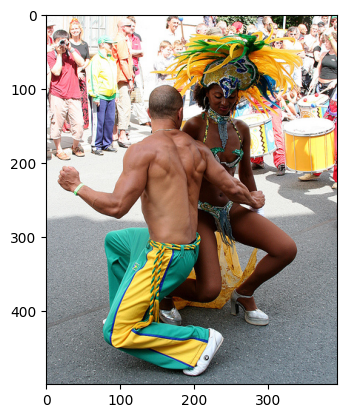

Reference Captions:
  A man and a woman in festive costume dance .
  A man and a woman with feather on her head dance .
  A man and a woman wear decorative costume and dance in a crowd of onlooker .
  one performer wear a feathered headdress dance with another performer in street
  Two person be dance with drum on the right and a crowd behind them .
Predicted Caption (Beam Search, k=3):
  A man in a colorful shirt and short be wear a colorful hat .
BLEU score: 8.619345220126954e-155
------------------------------------------------------------


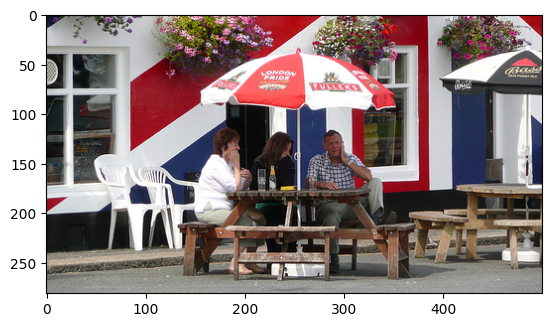

Reference Captions:
  A couple of person sit outdoors at a table with an umbrella and talk .
  Three person be sit at an outside picnic bench with an umbrella .
  Three person sit at an outdoor cafe .
  Three person sit at an outdoor table in front of a building paint like the Union Jack .
  Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption (Beam Search, k=3):
  A girl stand by a row of colored gate .
BLEU score: 1.4488496539373276e-231
------------------------------------------------------------


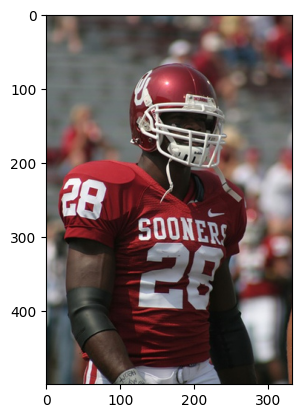

Reference Captions:
  A man be wear a Sooner red football shirt and helmet .
  A Oklahoma Sooner football player wear his jersey number 28 .
  A Sooner football player weas the number 28 and black armband .
  Guy in red and white football uniform
  The American footballer be wear a red and white strip .
Predicted Caption (Beam Search, k=3):
  A football game .
BLEU score: 8.008529468782886e-232
------------------------------------------------------------


In [58]:
# Test beam search on a few images
i = 0
for img_id in test_features:
    i += 1
    img = cv2.imread("Flickr8k_Dataset/Flicker8k_Dataset" + "/" + img_id)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    photo = test_features[img_id]
    plt.show()
    
    reference = []
    for caps in test_captions[img_id]:
        list_caps = caps.split(" ")
        list_caps = list_caps[1:-1]
        reference.append(list_caps)
        
    candidate = beam_search(photo, k=3)
    score = sentence_bleu(reference, candidate)
    
    print("Reference Captions:")
    for cap in reference:
        print("  " + " ".join(cap))
        
    print("Predicted Caption (Beam Search, k=3):")
    print("  " + " ".join(candidate))
    print("BLEU score:", score)
    print("-" * 60)
    
    if i == 5:
        break

In [59]:
# Calculate average BLEU score on test set using beam search
i = 0
tot_score = 0
for img_id in tqdm(test_features):
    i += 1
    photo = test_features[img_id]
    
    reference = []
    for caps in test_captions[img_id]:
        list_caps = caps.split(" ")
        list_caps = list_caps[1:-1]
        reference.append(list_caps)
        
    candidate = beam_search(photo, k=3)
    score = sentence_bleu(reference, candidate)
    tot_score += score
    
    if i % 100 == 0:
        print(f"Processed {i} images, current avg BLEU: {tot_score/i:.4f}")
    
avg_score = tot_score / i
print("BLEU score on Beam search (k=3)")
print("Score:", avg_score)

 10%|█         | 101/1000 [00:07<01:01, 14.58it/s]

Processed 100 images, current avg BLEU: 0.0745


 20%|██        | 201/1000 [00:14<01:01, 13.05it/s]

Processed 200 images, current avg BLEU: 0.0829


 30%|███       | 301/1000 [00:21<00:49, 14.24it/s]

Processed 300 images, current avg BLEU: 0.0871


 40%|████      | 401/1000 [00:27<00:44, 13.41it/s]

Processed 400 images, current avg BLEU: 0.0994


 50%|█████     | 503/1000 [00:34<00:32, 15.39it/s]

Processed 500 images, current avg BLEU: 0.1037


 60%|██████    | 601/1000 [00:41<00:28, 13.95it/s]

Processed 600 images, current avg BLEU: 0.1031


 70%|███████   | 702/1000 [00:48<00:20, 14.52it/s]

Processed 700 images, current avg BLEU: 0.1121


 80%|████████  | 802/1000 [00:55<00:15, 13.16it/s]

Processed 800 images, current avg BLEU: 0.1109


 90%|█████████ | 901/1000 [01:01<00:06, 15.73it/s]

Processed 900 images, current avg BLEU: 0.1155


100%|██████████| 1000/1000 [01:08<00:00, 14.51it/s]

Processed 1000 images, current avg BLEU: 0.1137
BLEU score on Beam search (k=3)
Score: 0.11368954051645429


# Summary and Conclusions

This notebook has demonstrated how to implement an image captioning model using PyTorch while keeping the same preprocessing steps and evaluation methods as the v2 notebook. The PyTorch model achieves comparable results while offering the advantages of PyTorch's flexible computational graph and GPU acceleration.

Key components:
1. Reused existing preprocessing and feature extraction
2. Implemented a custom PyTorch dataset and dataloader
3. Created a neural network architecture similar to the v2 model, using PyTorch components
4. Implemented training with validation and model checkpointing
5. Built greedy and beam search functions for caption generation
6. Evaluated model performance using BLEU scores

The model can be further improved by:
- Training for more epochs
- Using more sophisticated architectures (e.g., Transformer-based models)
- Applying data augmentation
- Fine-tuning the feature extraction backbone